In [3]:
import concurrent.futures
from itertools import product

import numpy as np
import pandas as pd
from tqdm import tqdm

from control_guided_nas import LINEAR_SYS, NON_LINEAR_SYS, get_max_diam

print(f"Linear systems: {LINEAR_SYS}, non-linear systems: {NON_LINEAR_SYS}")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


Linear systems: ['F1', 'CC'], non-linear systems: ['CAR']


In [2]:
get_max_diam(0.005, 1-0.64, "F1")

2.5210186141964024

In [2]:
# systems = LINEAR_SYS + NON_LINEAR_SYS
systems = LINEAR_SYS
latency = np.linspace(0.001, 0.050, 50)
accuracy = np.linspace(0.5, 1.0, 50)

rows = []

# Example usage of maximum diameter calculation
# diameter = get_max_diam(0.02, (1 - 0.8), "F1")

with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    futures_to_args = {}
    for argset in product(systems, latency, accuracy):
        s, L, a = argset
        futures_to_args[executor.submit(get_max_diam, L, 1 - a, s)] = argset

    print(argset)
    with tqdm(total=len(futures_to_args)) as pbar:
        for future in concurrent.futures.as_completed(futures_to_args):
            try:
                diameter = future.result()
                rows.append([*futures_to_args[future], diameter])
                pbar.update(1)
            except AttributeError as e:
                print(e)
                print(futures_to_args[future])

# for sys in systems:
#     for l in latency:
#         for a in accuracy:
#             rows.append([l, a, sys, diam(l, a, sys)[1]])

df = pd.DataFrame(rows, columns=["system", "latency", "accuracy", "diameter"])
df

# Plotting
# for sys in ["F1", "CC"]:
#     for setup in ["l11_tcp", "l15_tcp", "l11_udp", "l15_udp"]:
#         plt.plot(range(1, 6), diameter[sys][setup], label=f"{sys} {setup}", marker="o", lw=4, markersize=15)
#     plt.xticks(range(1, 6), fontsize=15)
#     plt.yticks(fontsize=15)
#     plt.xlabel("Network loss (%)", fontsize=20)
#     plt.ylabel("Max diameter of reachable sets (m)", fontsize=20)
#     # plt.title("Reachability analysis with a simplified cruise control model", fontsize=18)
#     plt.legend(fontsize=15)
#     plt.show()

('CC', np.float64(0.05), np.float64(1.0))


100%|██████████| 5000/5000 [03:16<00:00, 25.38it/s] 


,system,latency,accuracy,diameter
0,F1,0.001,0.510204,12.729926
1,F1,0.001,0.551020,6.953781
2,F1,0.001,0.571429,5.141776
3,F1,0.001,0.520408,10.942085
4,F1,0.001,0.500000,14.812122
...,...,...,...,...
4995,CC,0.050,0.989796,0.684533
4996,CC,0.050,0.959184,0.824604
4997,CC,0.050,0.969388,0.775375
4998,CC,0.050,0.918367,1.027982


`polytope` failed to import `cvxopt.glpk`.
`polytope` failed to import `cvxopt.glpk`.
`polytope` failed to import `cvxopt.glpk`.
`polytope` failed to import `cvxopt.glpk`.
`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`
will use `scipy.optimize.linprog`
will use `scipy.optimize.linprog`
`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`
will use `scipy.optimize.linprog`
will use `scipy.optimize.linprog`
`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`
`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [17]:
df.to_csv("diameters_v6.csv", index=False)

In [2]:
df = pd.read_csv("diameters_v6.csv")

In [4]:
df

,system,latency,accuracy,diameter
0,F1,0.001,0.530303,9.449740
1,F1,0.001,0.535354,8.768675
2,F1,0.001,0.525253,10.183973
3,F1,0.001,0.515152,11.829086
4,F1,0.001,0.500000,14.812122
...,...,...,...,...
2995,CC,0.015,0.969697,0.729203
2996,CC,0.015,0.984848,0.661366
2997,CC,0.015,0.979798,0.683718
2998,CC,0.015,0.989899,0.639215


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_scan(df: pd.DataFrame, sysname: str):
    data = df[df["system"] == sysname]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    latency_vals = data["latency"].values
    accuracy_vals = data["accuracy"].values
    diameter_vals = data["diameter"].values
    minima = np.argmin(diameter_vals)

    surf = ax.plot_trisurf(
        latency_vals, accuracy_vals, diameter_vals, cmap="viridis", edgecolor="none"
    )
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    ax.scatter(
        latency_vals[minima],
        accuracy_vals[minima],
        diameter_vals[minima],
        s=100,
        marker="o",
        color="red",
    )

    ax.set_xlabel("Latency")
    ax.set_ylabel("Accuracy")
    ax.set_zlabel("Diameter")

    # def update(frame):
    #     ax.view_init(elev=30, azim=frame)
    #     return fig,

    # ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 5), interval=100, blit=True)
    # ani.save(f'{sysname}.gif', writer=PillowWriter(fps=10))

    ax.view_init(elev=30, azim=120)
    plt.show()

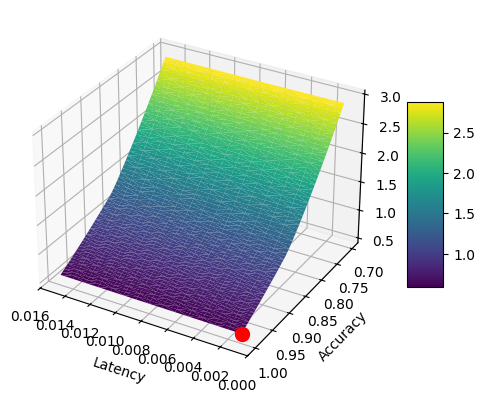

In [3]:
plot_scan(df.loc[(df["accuracy"] > 0.7)], "CC")

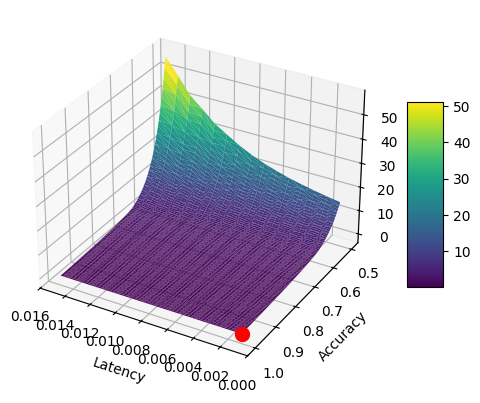

In [4]:
# plot_scan(df.loc[(df["accuracy"] > 0.7)], "CC")
plot_scan(df, "F1")

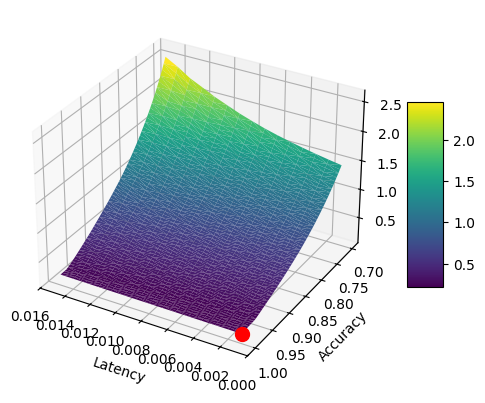

In [5]:
plot_scan(df.loc[(df["accuracy"] > 0.7)], "F1")
# plot_scan(df, "F1")

In [ ]:
df.loc[(df["system"] == "F1") & (df["latency"] == 0.02) & (df["accuracy"] > 0.9)]

,system,latency,accuracy,diameter
92,F1,0.02,0.90,4.251688
96,F1,0.02,0.94,2.968431
97,F1,0.02,0.98,2.258760
98,F1,0.02,0.92,3.582026
100,F1,0.02,0.96,2.415040
